<a href="https://colab.research.google.com/github/nnanna217/msc-image-search/blob/main/msc_search_color_histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Color Histogram Embedding and Search

Src - Adapted from [Pinecone](https://github.com/pinecone-io/examples/blob/color-histograms/learn/image-retrieval/color-histograms/01-search-histogram.ipynb)


Building color histograms and apply it to create image embeddings and use them in search.

Load the images from HuggingFace *Datasets*.

In [ ]:
!pip install datasets

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from datasets import load_dataset
# Load the dataset
dataset = load_dataset('SaffalPoosh/deepFashion-with-masks', split='train[:100]')

def process_fn(sample):
    image_item = sample['images']
    image = np.array(image_item)
    return image

# image=process_fn(dataset[0])
# Assuming you have an image array named 'image'
# plt.imshow(image)
# plt.axis('off')
# plt.show()

images = [process_fn(sample) for sample in dataset]


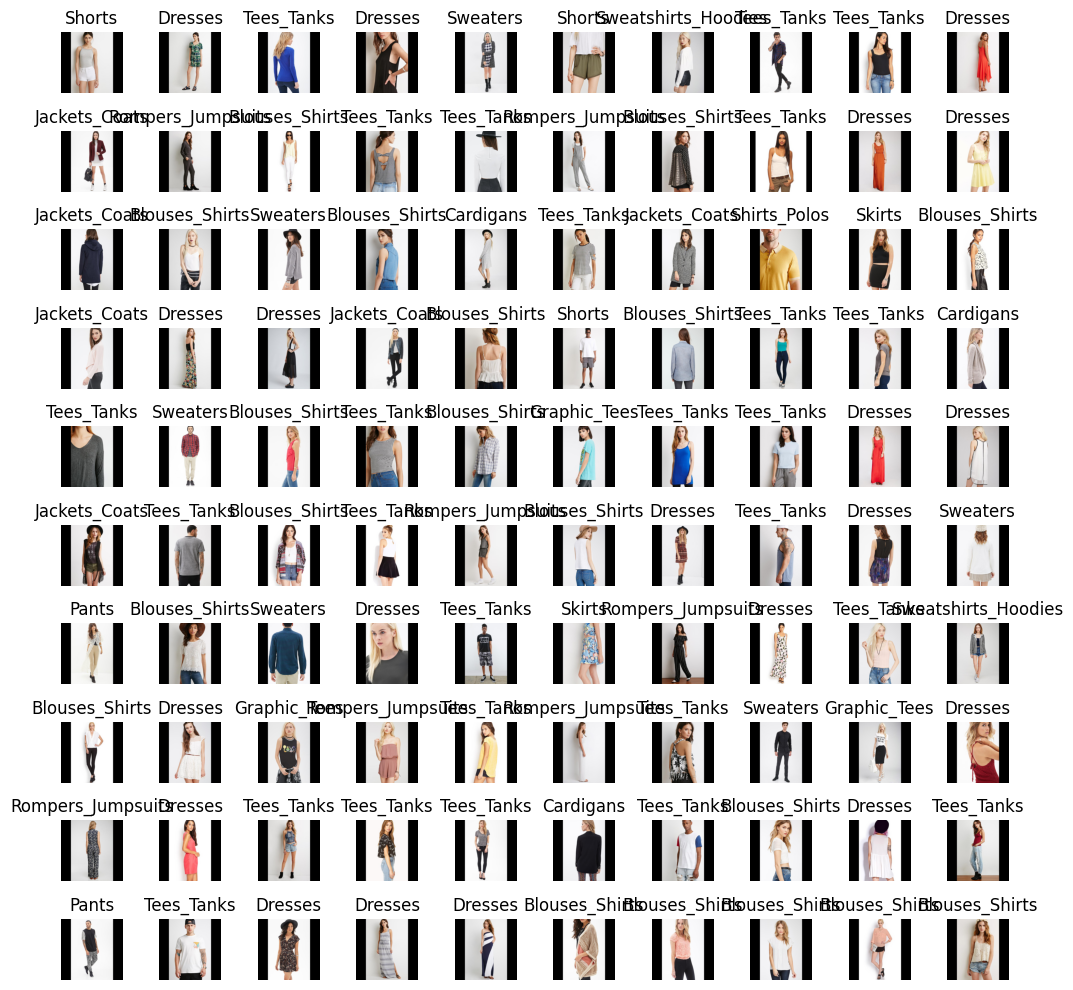

In [ ]:
def display_images(dataset):
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(100):
        image = dataset[i]['images']
        label = dataset[i]['cloth_type']
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(label)

    plt.tight_layout()
    plt.show()

# Display the images
display_images(dataset)


A function to build the RGB histograms and transform them into a single vector.

Vectors are used because they can compare vectors using metrics like Euclidean distance or cosine similarity.

In [ ]:
def get_vector(image, bins=32):
    red = cv2.calcHist([image], [2], None, [bins], [0, 256])
    green = cv2.calcHist([image], [1], None, [bins], [0, 256])
    blue = cv2.calcHist([image], [0], None, [bins], [0, 256])
    vector = np.concatenate([red, green, blue], axis=0)
    vector = vector.reshape(-1)
    return vector

In [ ]:
vec = get_vector(images[0])
vec.shape

(96,)

Now we have a single vector representation of our image color histograms, values [0, ..., 32] are red, [32, ..., 64] are green, and [64, ..., 96] are blue.

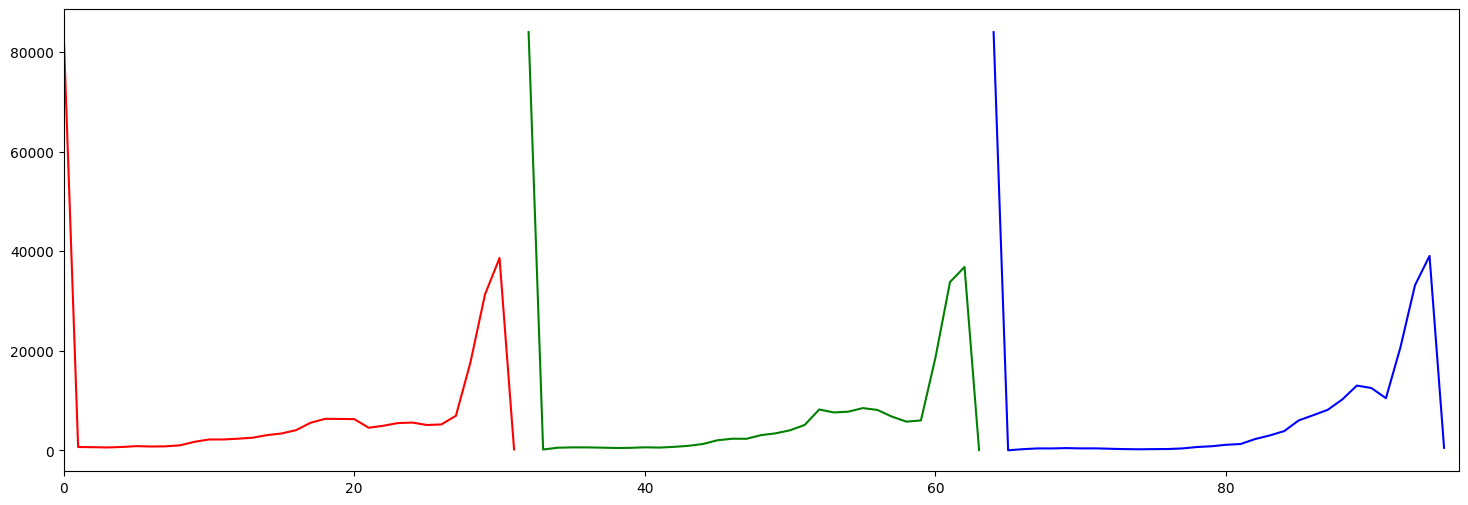

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

plt.plot(list(range(32)), vec[:32], color='red')
plt.plot(list(range(32, 64)), vec[32:64], color='green')
plt.plot(list(range(64, 96)), vec[64:96], color='blue')

plt.xlim(0, 96)

plt.show()

Extract vectors for all images

In [ ]:
image_vectors = []
for image in images:
    image_vectors.append(get_vector(image))

Now we can compare vectors with Euclidean distance, calculated with Numpy like so:

In [ ]:
dist = np.linalg.norm(image_vectors[0] - image_vectors[1])
dist

62702.414

Or using cosine similarity, as shown in the `cosine` function below:

In [ ]:
def euclidean(a, b):
    return np.linalg.norm(a - b)

def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

We use this to find the most similar matches for each image, we'll do this within a function to keep everything clean.

In [ ]:
# during visualization we use this array of RGB images
rgb_images = np.array([np.flip(image, 2) for image in images])

def search(idx, top_k=5):
    query_vector = image_vectors[idx]
    distances = []
    for _, vector in enumerate(image_vectors):
        distances.append(cosine(query_vector, vector))
    # get top k most similar images
    top_idx = np.argpartition(distances, -top_k)[-top_k:]
    return top_idx

In [ ]:
search(0)

array([11, 93, 31, 91,  0])

Let's write another function to help us visualize these results.

In [ ]:
def visualize(query_i, results_i):
    query = rgb_images[query_i]
    span = int(len(image_vectors[0])/3)
    results = rgb_images[results_i]
    top_k = len(results)
    # visualize query image and it's color histogram
    fig, axs = plt.subplots(1, 2, figsize=(18, 10))
    axs[0].imshow(query)
    axs[0].axis('off')
    axs[1].plot(image_vectors[query_i][:span], 'r', label='red')
    axs[1].plot(image_vectors[query_i][span:span*2], 'g', label='green')
    axs[1].plot(image_vectors[query_i][span*2:], 'b', label='blue')
    plt.show()
    # visualize top k images and their color histograms
    fig0, axs0 = plt.subplots(1, top_k, figsize=(top_k*5, 5))
    fig1, axs1 = plt.subplots(1, top_k, figsize=(top_k*5, 5), sharey=True)
    for i in range(top_k):
        axs0[i].imshow(results[i])
        axs0[i].axis('off')
        axs1[i].plot(image_vectors[results_i[i]][:span], 'r', label='red')
        axs1[i].plot(image_vectors[results_i[i]][span:span*2], 'g', label='green')
        axs1[i].plot(image_vectors[results_i[i]][span*2:], 'b', label='blue')

In [ ]:
results_i = search(0)

In [ ]:
results_i

array([11, 93, 31, 91,  0])

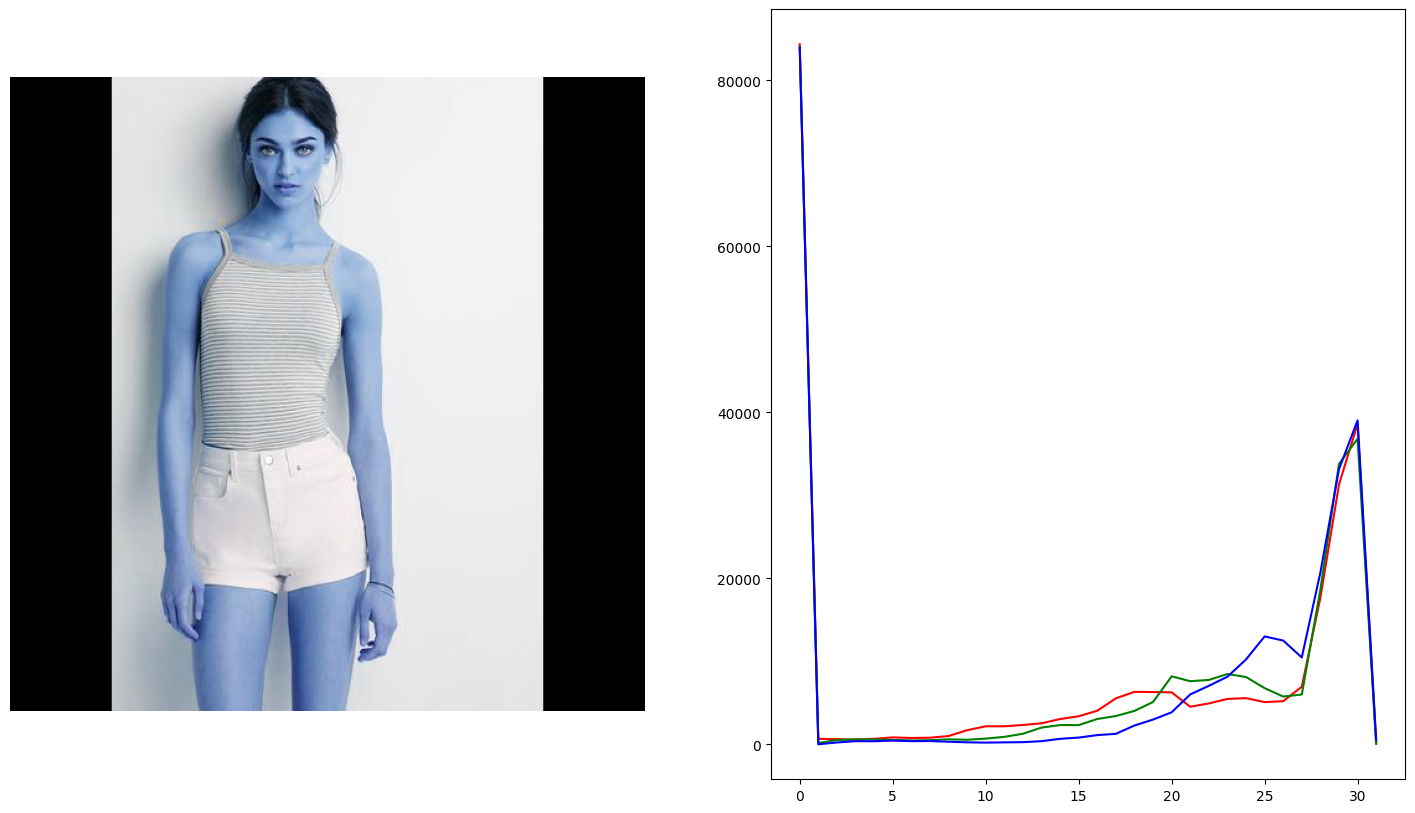

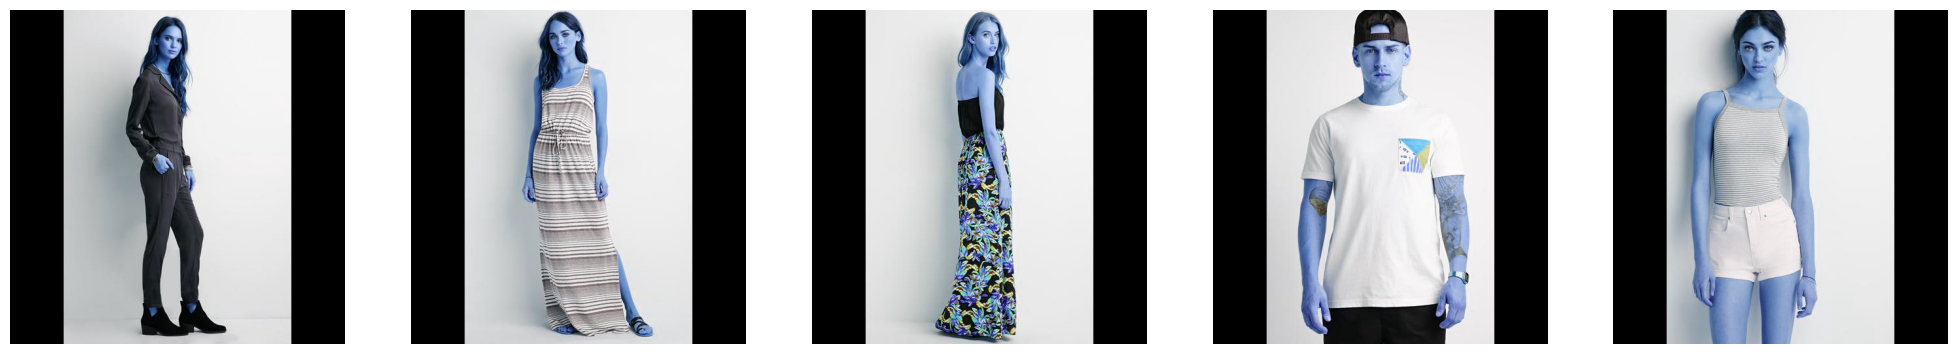

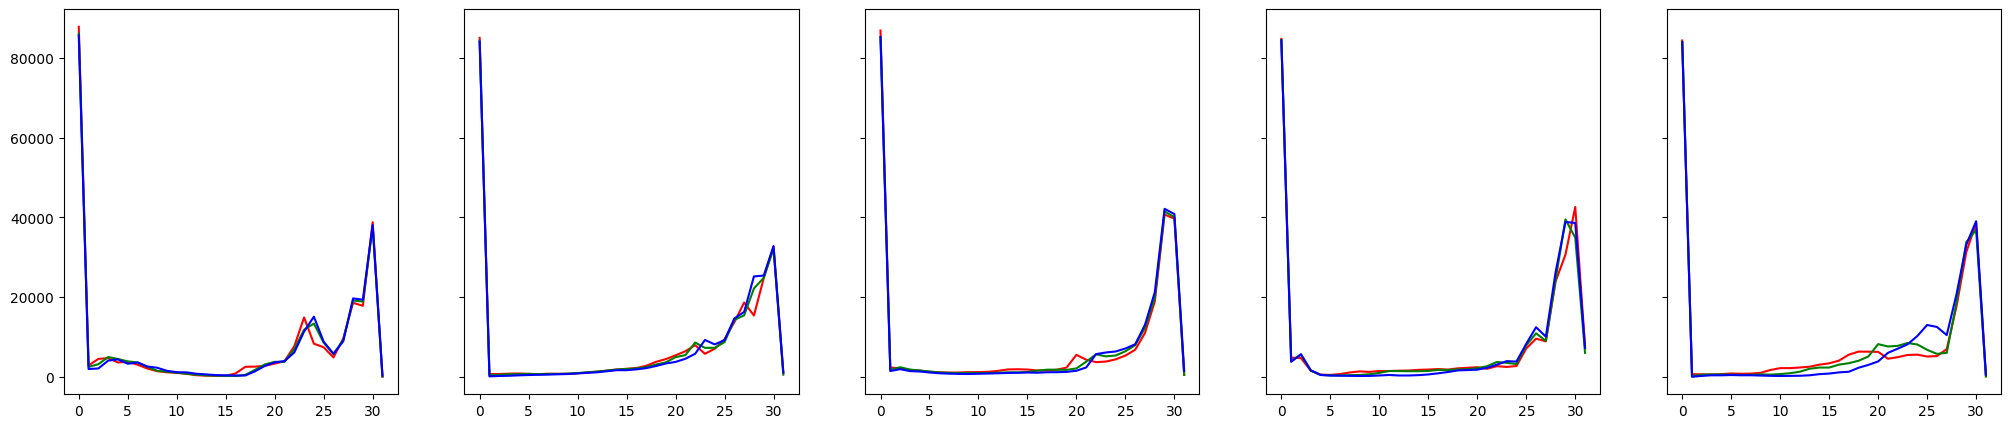

In [ ]:
img = 0
visualize(img, search(img))

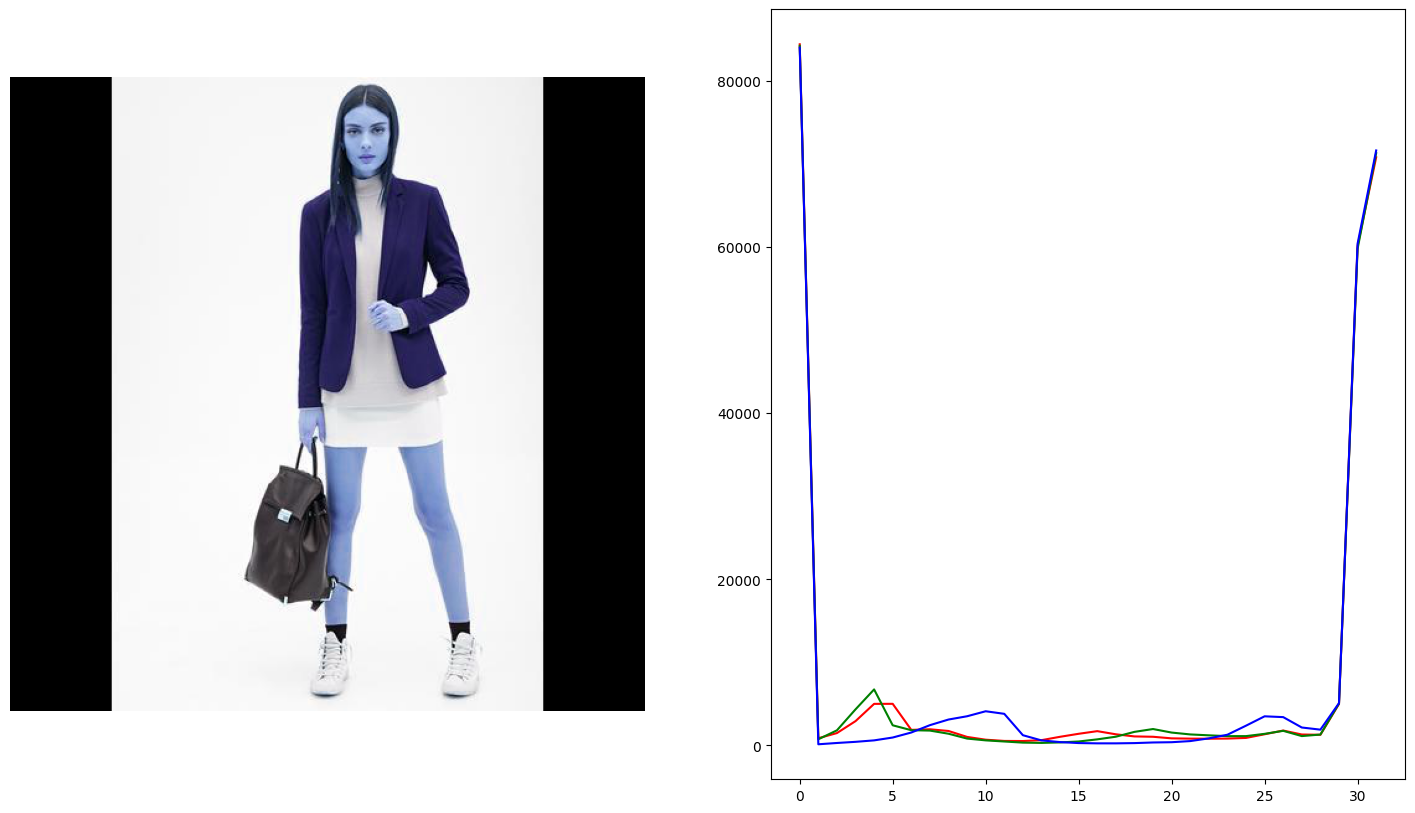

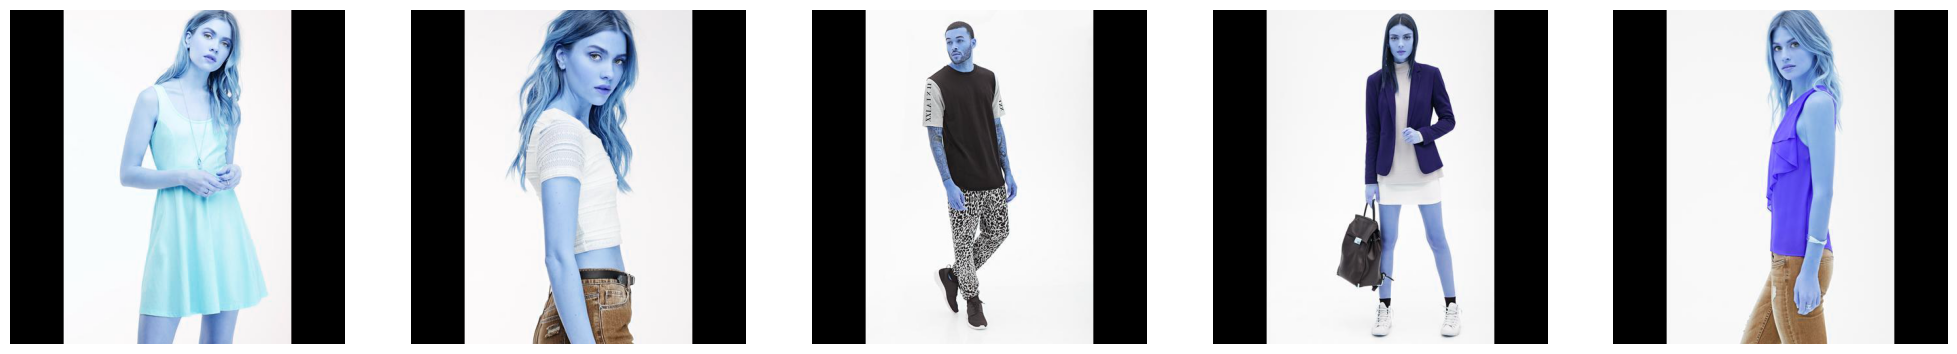

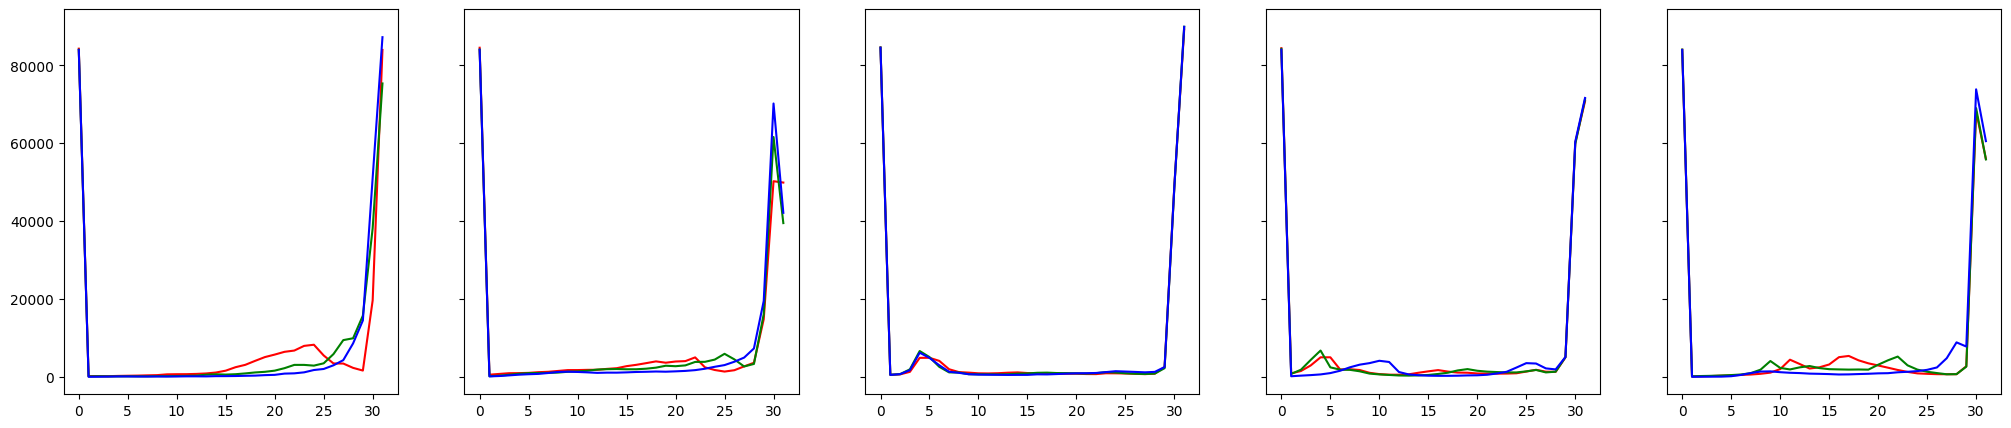

In [ ]:
img = 10
visualize(img, search(img))

Let's see the effect of modifying the number of bins.

In [ ]:
image_vectors = []
for image in images:
    image_vectors.append(get_vector(image, bins=96))

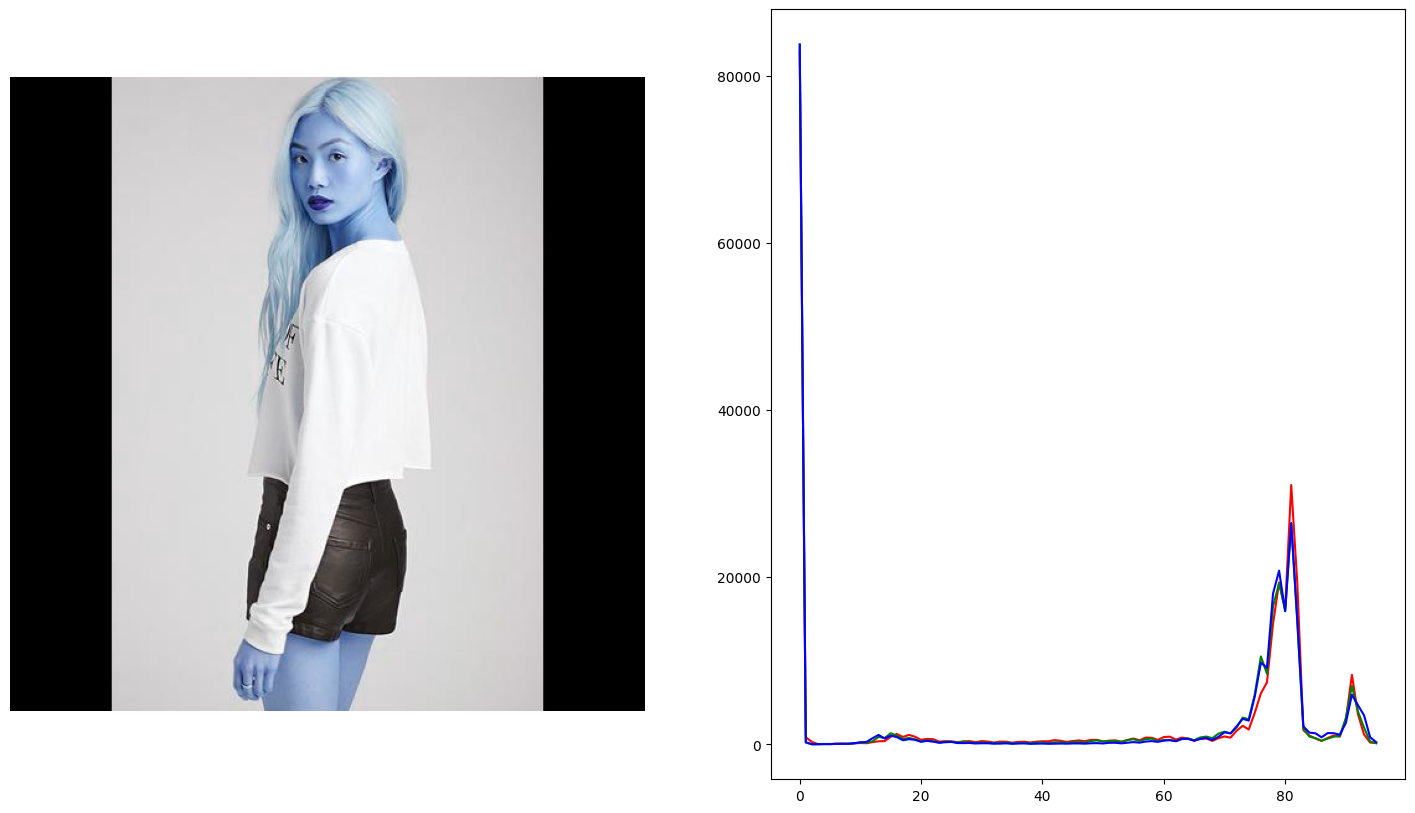

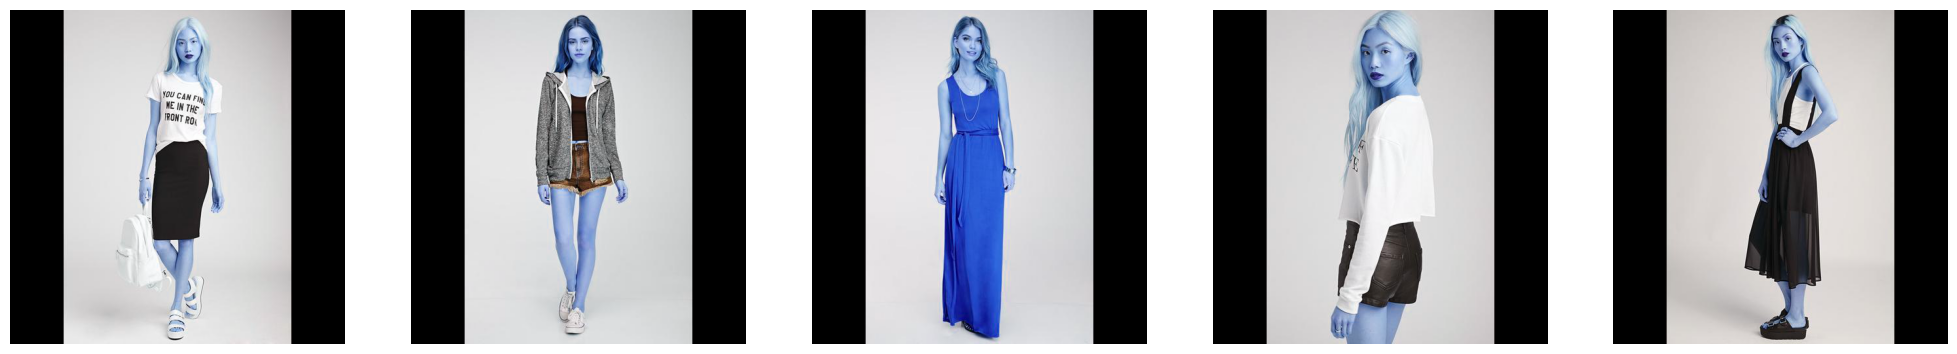

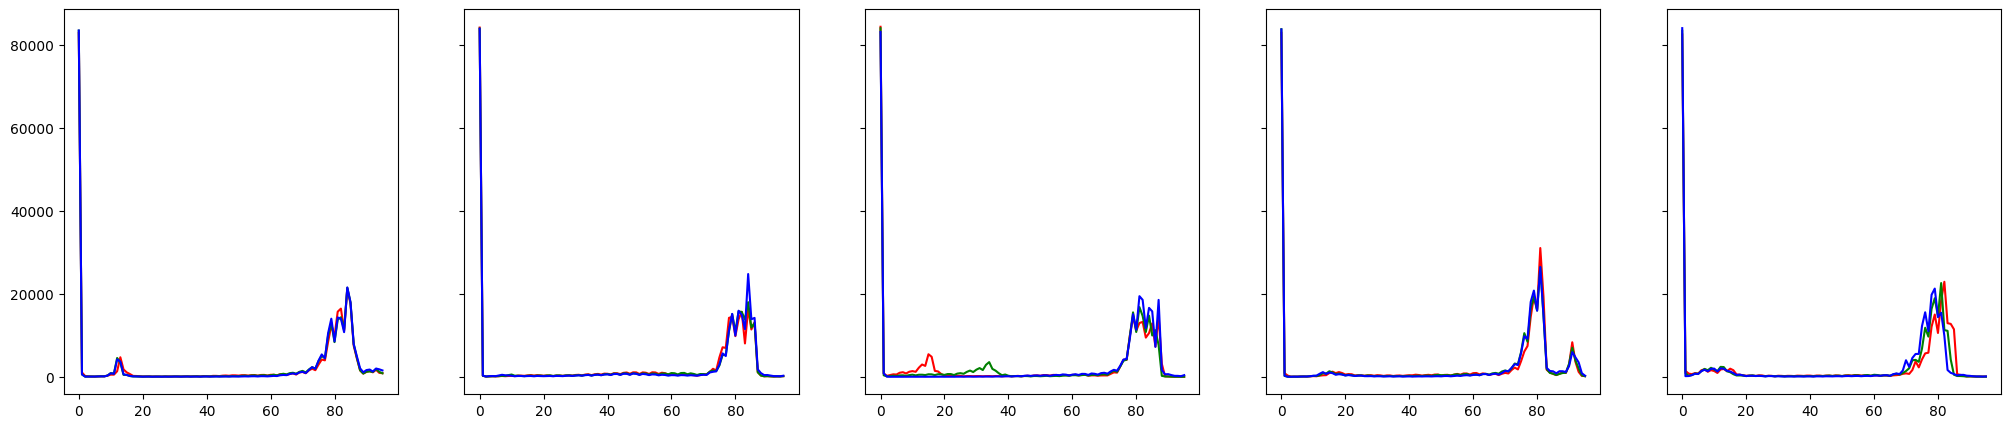

In [ ]:
img = 6
visualize(img, search(img))

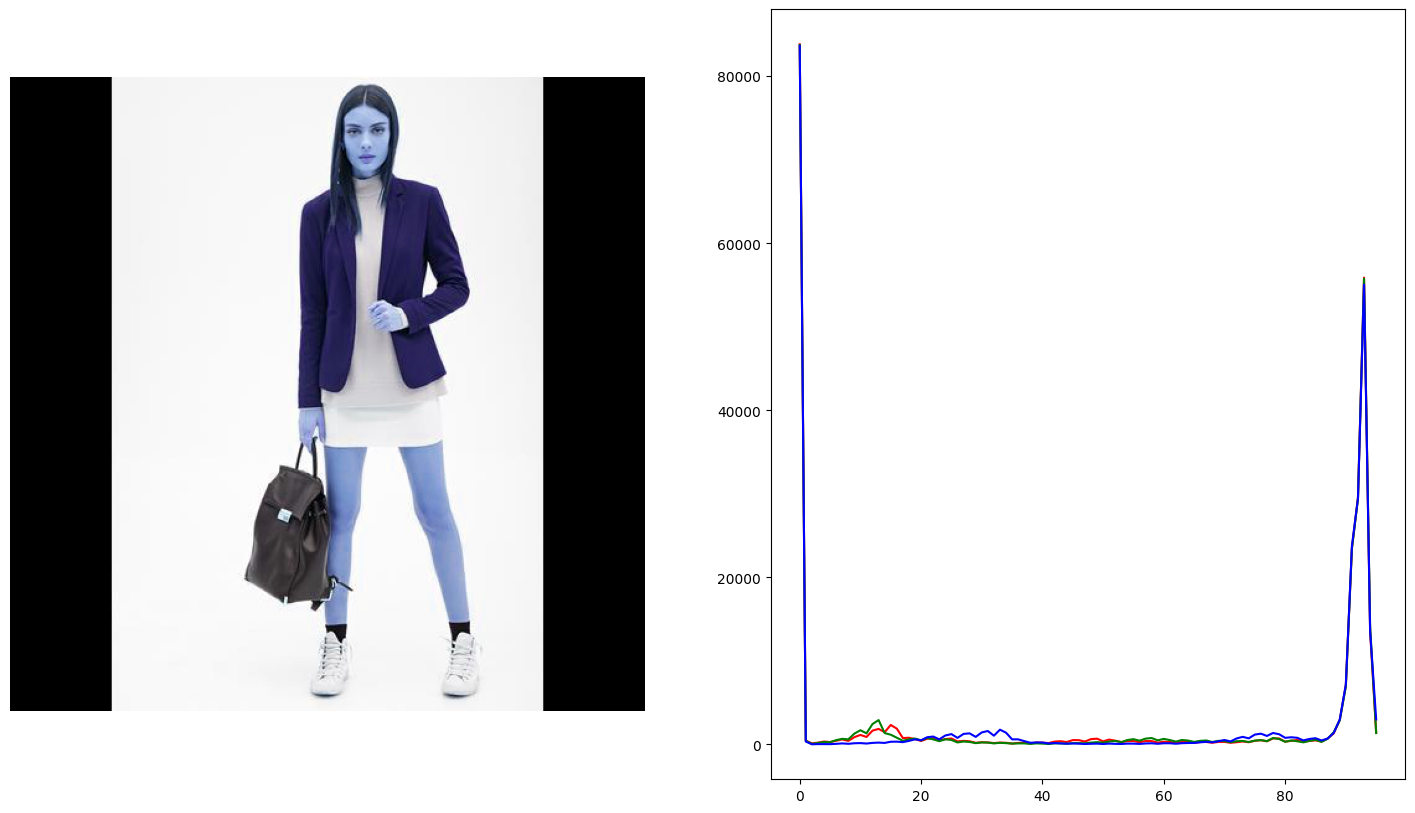

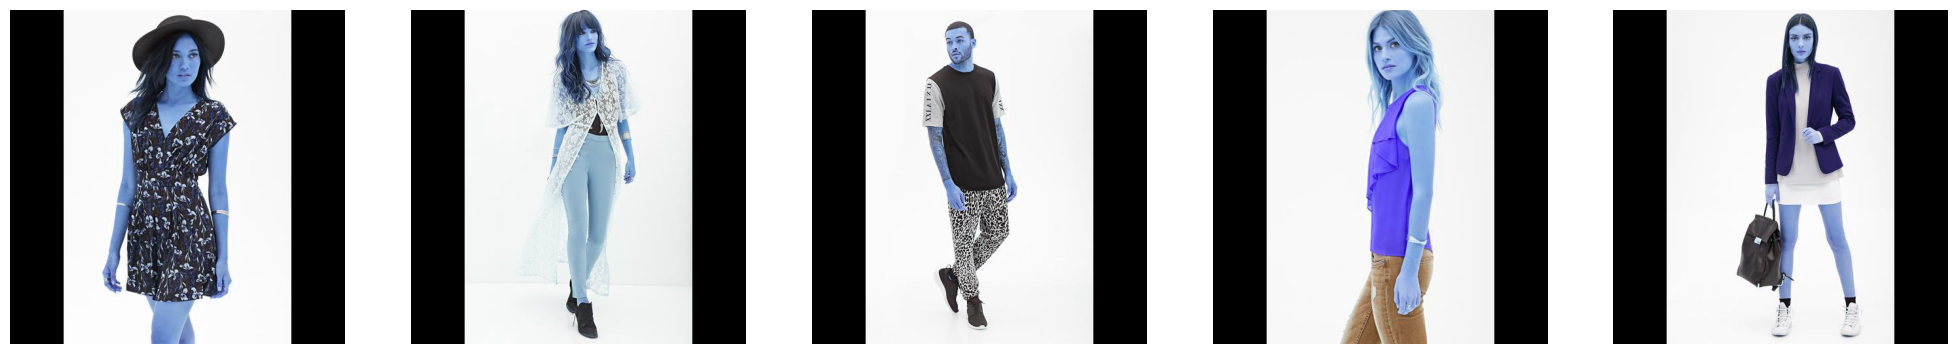

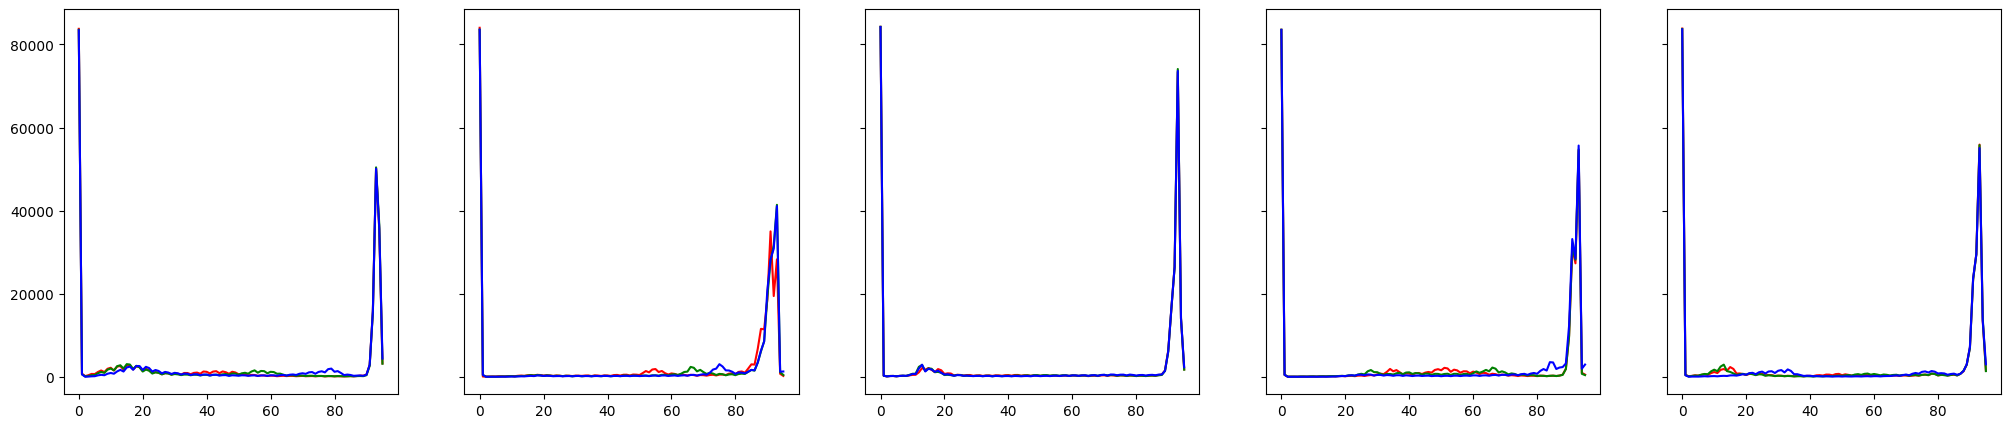

In [ ]:
img = 10
visualize(img, search(img))

In [ ]:
image_vectors = []
for image in images:
    image_vectors.append(get_vector(image, bins=256))

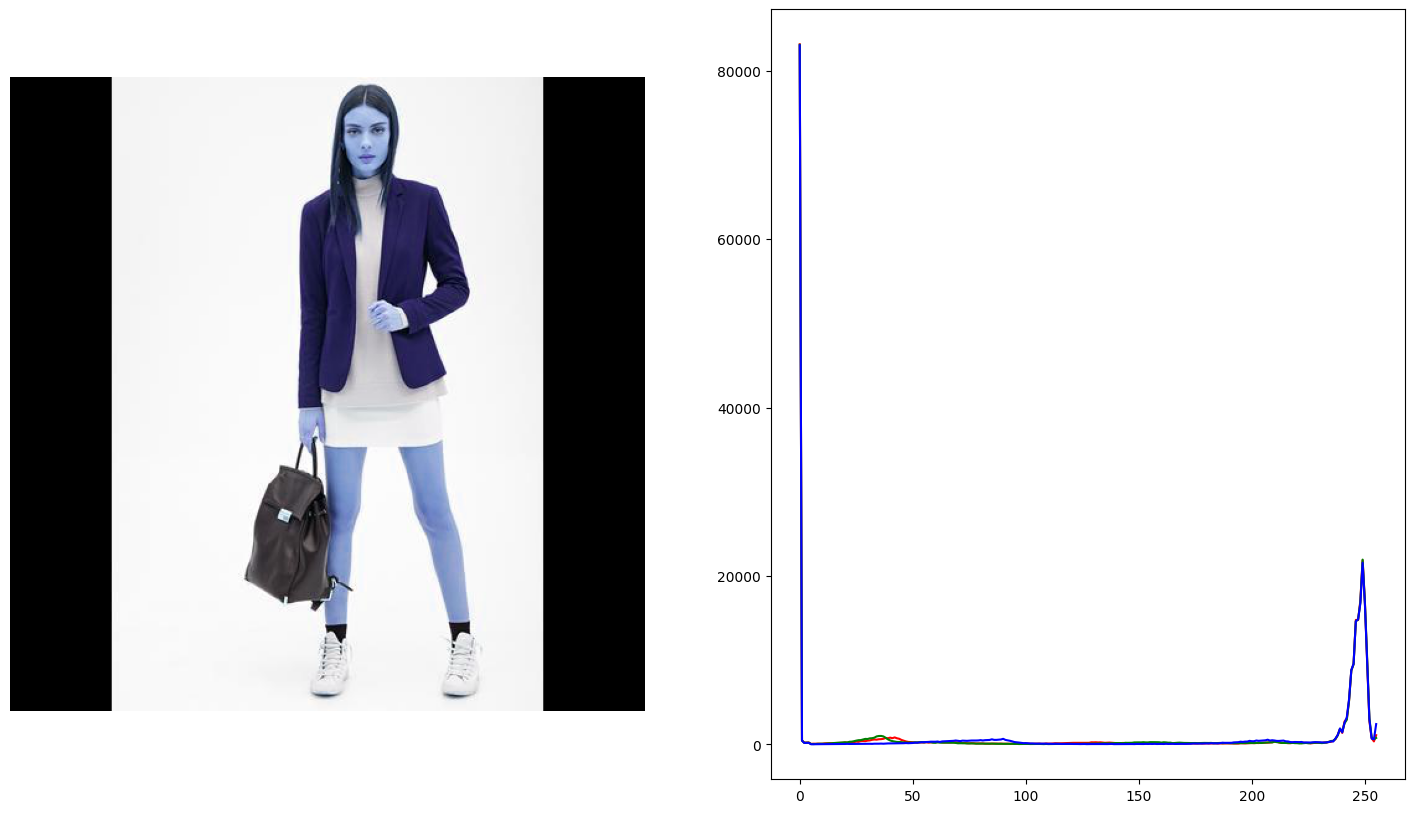

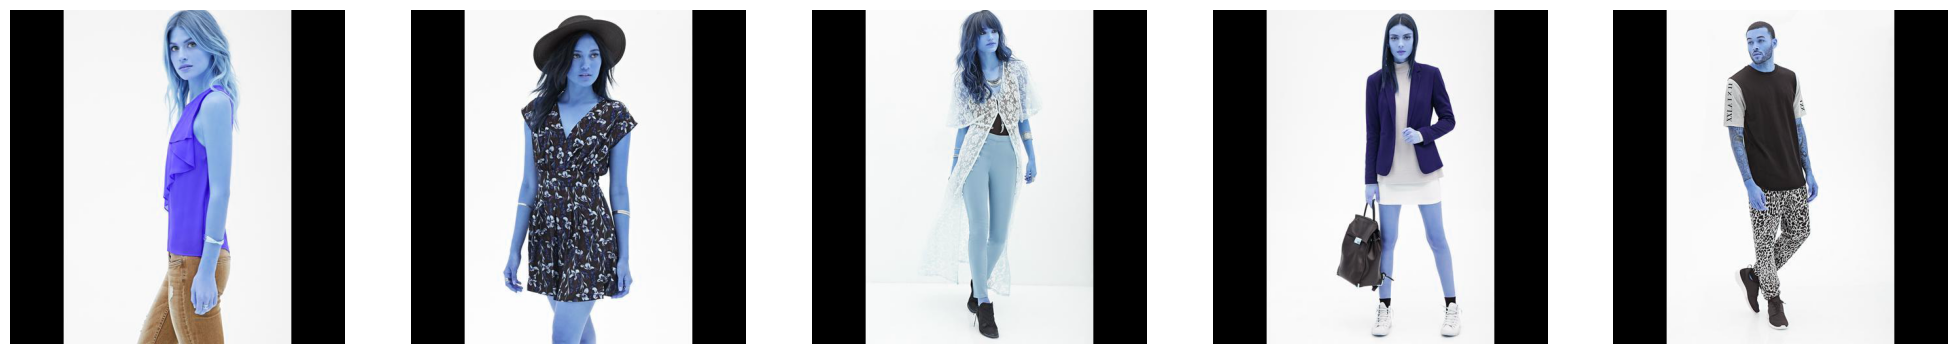

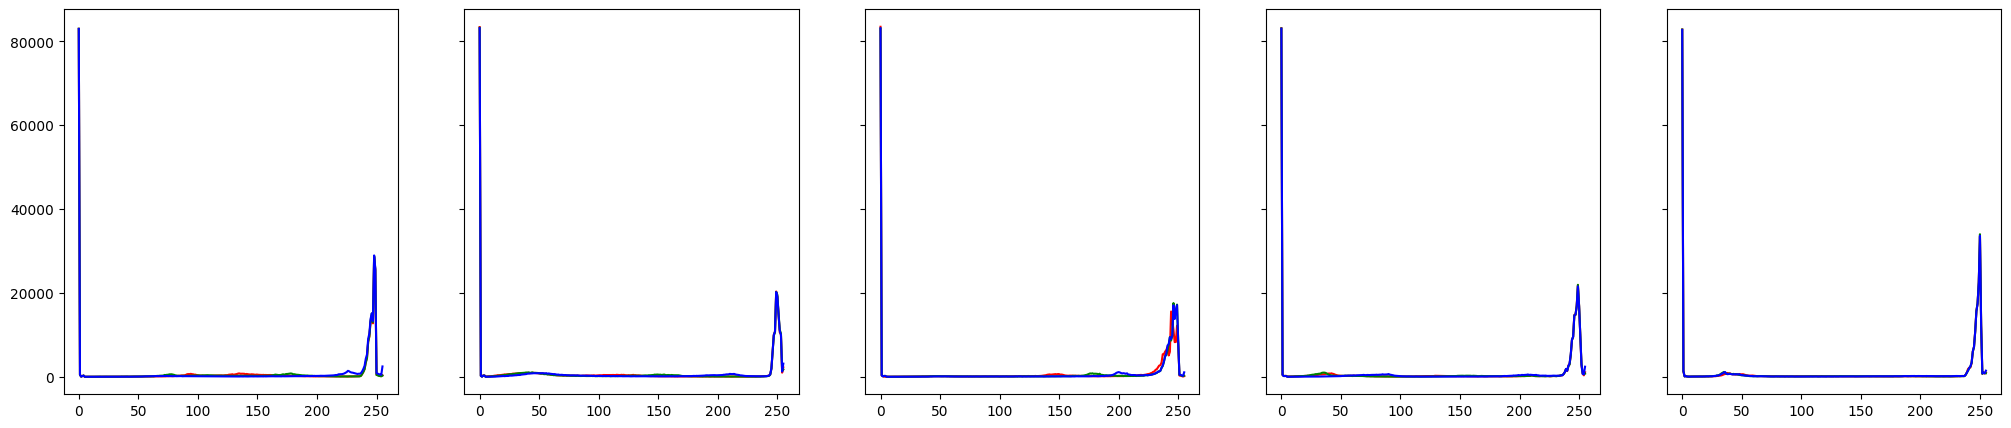

In [ ]:
img = 10
visualize(img, search(img))